# Comparison of Different Algorithmic Trading Strategies on Tesla Stock Price

### Tawfiq Jawhar
<b>Machine Learning (COMP-652 and ECSE-608)<br>
Fall 2018<br>
McGill University <br><br>
Instructors:<br>
Audrey Durand<br>
Riashat Islam <br></b>

---

## Outline
We will start building and testing our first strategy. Moving Average strategies are simple and well used in algorithmic trading. We will use Simple Moving Average (SMA), which is a very simple strategy. SMA(N) is the N-day simple moving average which is the mean of price for the past N days. In our trading environment, the trading is happening every day at market opening time. We will be looking at the closing prices for the days before and the open price for the day of trading. SMA is calculated:

$$ SMA(N) = \frac{\sum_{i=t-N}^{t-1}{Closing Price_i}+ OpeningPrice_t}{N} $$

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
//to show the full output without scrolling

<IPython.core.display.Javascript object>

In [2]:
## to use zipline magic commands (which is not used in this notebook)
%load_ext zipline
## inline plot
%matplotlib inline

##import libraries
import zipline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('seaborn-darkgrid')
#plt.style.use('bmh')

import pickle
import numpy as np
from zipline.api import (
    order_target_percent, 
    record, 
    symbol, 
    schedule_function, 
    sid,
    date_rules,
    time_rules,
    get_open_orders,
    order_percent,
    order,
    set_benchmark)
from zipline.finance import commission, slippage
from zipline import run_algorithm

## pyfolio was not installed in the docker image (needs updating)
## if you want to use pyfolio to analyze the portfolio
try:
    import pyfolio as pf
except:    
    !pip install pyfolio
    import pyfolio as pf
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy import unravel_index
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

## SMA - Simple Moving Average Strategy
The SMA strategy is simple. We calculate $SMA(N)$ and $SMA(M)$, where $M > N$. 
```
IF SMA(N) > SMA(M) THEN
    IF NOT Invested THEN
        BUY
ELSE 
    IF Invested THEN
        SELL
```
However, choosing N and M can be difficult. We will use Bayesian Optimization to optimize for N and M. 

## Objective Function
Looking at the return at the end of the backtesting is not enough to decide whether a strategy is doing well or not. If a strategy has a high volatility (standard deviation of the return over the period of trading) then even if the return is high at the end, the strategy has a high risk factor. 

The Sharpe Ratio is a popular performace measure used in algorithmic trading. Sharpe Ratio calculates the risk-adjusted return. 

$$ Sharpe Ratio = \frac{R_p - R_f}{\sigma_p}$$

Where:

$R_p$ is the expected portfolio return<br>
$R_f$ is the risk free rate<br>
and $\sigma_p$ is the portfolio standard deviation

Zipline uses free risk rates from the US treasuries data repository. 

<b>We will use the Sharpe Ratio as our objective for optimization. </b>

## Trading Environment
We will use the same trading environment we are using throughout this project. We will optimize SMA strategy on the training time period and then we will compare the result from the testing time period to the result from the Buy and Hold strategy that we are using as a benchmark. 

In [3]:
## Dictionary to hold environment information.
env = {
    'train': {
        'start_time': pd.to_datetime('2014-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2015-12-31').tz_localize('US/Eastern')
    },
    'test': {
        'start_time': pd.to_datetime('2016-01-01').tz_localize('US/Eastern'),
        'end_time': pd.to_datetime('2017-12-31').tz_localize('US/Eastern')
    },
    'commision': None, #commission.PerShare(cost=.0075, min_trade_cost=1.0)
    'slippage': None, #slippage.VolumeShareSlippage()
    'capital': 100000, #USD
    'stock': 'TSLA',
    'date_rules': date_rules.every_day(),
    'time_rules': time_rules.market_open()
}

## SMA Optimization

We will use Bayesian Optimization with GP-UCP acquisition function. To make sure our optimization is not over fitting on the training set, the objective function will run the backtesting on 4 different time periods (6 months each). And the objective value will be the sum of the 4 sharpe ratios for every time period.

We will set the range of short SMA [1,10] and long SMA [11,60]. We will initialize with 5 random points.

There are 551 possible combinations of SMA short and long. We will use 40 iterations after the initialization. With a total of 45 points tested, which is less than 10% of all the possible combinations.

In [4]:
## SMA parameters
param = {
    'SMA_short' : 5,
    'SMA_long'  : 10
}

In [5]:
## Zipline strategy implementation
def analyze(context=None, results=None):
    fig = plt.figure(figsize=(10,15))
    ax1 = plt.subplot2grid((6,3),(0,0),colspan=3,rowspan=2)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = plt.subplot2grid((6,3),(2,0),colspan=3,rowspan=2)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if env['stock'] in results and 'sma_long' in results and 'sma_short' in results:
        results[['TSLA', 'sma_long', 'sma_short']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'sma_short'],
            '^',
            markersize=10,
            color='m',
            label ='buy',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'sma_long'],
            'v',
            markersize=10,
            color='k',
            label='sell',
        )
        plt.legend(loc=0)
    else:
        msg = env['stock']+' data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
    #ticks = ax2.get_xticks()
    #labels = ax2.get_xticklabels()
    #ax1.get_shared_x_axes().join(ax1, ax2)
    #ax2.set_xticks(ticks)
    #ax2.set_xticklabels(labels)
    ax3 = plt.subplot2grid((6,3),(4,0),colspan=3,rowspan=1)
    ax3.set_ylabel('Sharpe Ratio')
    results.sharpe.plot(ax=ax3)
    #ax3.set_ylim(-1,2)
    
    ax4 = plt.subplot2grid((6,3),(5,0),colspan=1,rowspan=1)
    ax4.set_ylabel("leverage")
    results.leverage.plot(ax=ax4)
    every_nth = 4
    for n, label in enumerate(ax4.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    ax5 = plt.subplot2grid((6,3),(5,1),colspan=2,rowspan=1)
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
    pf.plot_monthly_returns_heatmap(returns,ax=ax5)
    plt.tight_layout()
    plt.show()

    
def initialize(context):
    context.invested = False
    context.asset = symbol(env['stock'])
    context.set_commission(env['commision'])
    context.set_slippage(env['slippage'])
    schedule_function(handle_data_daily, env['date_rules'], env['time_rules'])
    

#Daily price history XXXXXXX
def handle_data_daily(context, data):
    hist = data.history(
        context.asset, 
        fields= 'price', 
        bar_count=param['SMA_long'], 
        frequency='1d'
    )
    
    hist[param['SMA_long']-1]=data.current(context.asset,'open')

    ## Calculate SMA(N) and SMA(M)
    sma_long = hist.mean()
    sma_short = hist[-param['SMA_short']:].mean()
    buy = False
    sell = False
     #If no open orders, balance 100% of portfolio to TSLA & 
     #execute scheduled market order if SMA_short is greater than SMA_long. 
    if sma_short > sma_long and not context.invested:
        order_percent(context.asset, 1.0)
        context.invested = True
        buy=True
    #If no open orders, short sell 100% of portfolio of TSLA & 
    #execute scheduled market order if SMA_long is greater than SMA_short. 
    elif sma_long > sma_short and context.invested: 
        order_percent(context.asset, -1.0)
        context.invested = False
        sell=True
    #Record results
    record(TSLA=data.current(context.asset, "price"),
           sma_long=sma_long,
           sma_short=sma_short,
           buy=buy,
           sell=sell)
    record(leverage=context.account.leverage)

    

In [6]:
## objective function
## Input new parameters for short and long and run the strategy
## return the sharpe ratio at the end of the trading period
period = [(pd.to_datetime('2014-01-01').tz_localize('US/Eastern'),pd.to_datetime('2014-06-30').tz_localize('US/Eastern')),
         (pd.to_datetime('2014-07-01').tz_localize('US/Eastern'),pd.to_datetime('2014-12-31').tz_localize('US/Eastern')),
         (pd.to_datetime('2015-01-01').tz_localize('US/Eastern'),pd.to_datetime('2015-06-30').tz_localize('US/Eastern')),
         (pd.to_datetime('2015-07-01').tz_localize('US/Eastern'),pd.to_datetime('2015-12-31').tz_localize('US/Eastern'))]
            
def objective(sma_short, sma_long):
    param['SMA_short'] = int(round(sma_short))
    param['SMA_long'] = int(round(sma_long))
    sharpe = 0
    for i in period:
        results = run_algorithm(i[0], i[1],
                        initialize=initialize,capital_base=env['capital'])    
        sharpe += results.sharpe[-1]
    return sharpe

def results(sma_short, sma_long):
    param['SMA_short'] = int(round(sma_short))
    param['SMA_long'] = int(round(sma_long))
    results = run_algorithm(env['test']['start_time'], env['test']['end_time'],
                        initialize=initialize,capital_base=env['capital'])
    return results

In [7]:
## Functions to visualize the space

## grid points for 3d plotting
y = np.linspace(11,60,100)
x = np.linspace(1, 10, 100)
xx_plot, yy_plot = np.meshgrid(x, y,indexing='ij')
XY = np.array([[xx,yy] for xx in x.flatten() for yy in y.flatten()])
shape = (100,100)

##Using the GP of the BO to predict the space
## and find mu and sigma 
## We fit the GP with the points already explored
def posterior(bo, XY):
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(XY, return_std=True)
    return mu, sigma

## Extract data from the bo GP
def plotting_data(bo, XY,xx_plot, yy_plot, title):
    
    ## mu, sigma
    mu, sigma = posterior(bo, XY)
    mu = mu.reshape(shape)
    sigma = sigma.reshape(shape)
    ## 95% confidence 
    conf = (1.9600 * sigma).reshape(shape)
    ## Utility 
    utility=bo.util.utility(XY,bo.gp,None).reshape(shape)
    ## Next Point
    nextPointArg = unravel_index(utility.argmax(), utility.shape)
    nextPoint = (xx_plot[nextPointArg], yy_plot[nextPointArg])
    ##Observations
    obsX = bo.X.T
    obsY = bo.Y
    return {'title':title,'mu':mu,'sigma':sigma,'conf':conf,'utility':utility,'nextpoint':nextPoint,'obsX':obsX,'obsY':obsY}
    
    
def plot_gp(xx_plot, yy_plot, plotting_data,min_obj,max_obj,min_util=None, max_util=None, min_conf=None, max_conf=None,ax=None):
    fontsize=15
    if(ax==None):
        fig = plt.figure(figsize=(5,5))
        ax = fig.gca(projection='3d')
        
    ##plot the 95% confidence interval as a contour plane at the minimum of the plot
    ## The vmin and vmax are important for subplots to have all the contour colors on the same scale
    cset_confidence = ax.contourf(xx_plot, yy_plot, plotting_data['conf'], zdir='z', offset=min_obj, 
                        cmap=cm.gray,vmin=min_conf, vmax=max_conf)

    ##plot utility function as a contour plane at the maximum of the plot
    cset_utility = ax.contourf(xx_plot, yy_plot, plotting_data['utility'], zdir='z', offset=max_obj,cmap=cm.autumn,alpha=0.5,
                      vmin=min_util,vmax=max_util)

    ##plot predictions from GP
    ax.plot_wireframe(xx_plot, yy_plot, plotting_data['mu'], rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.viridis)

    ##plot Observations
    x1 = plotting_data['obsX'][0]
    x2 = plotting_data['obsX'][1]
    
    ax.scatter3D(x1, x2, plotting_data['obsY'],color='r',s=50,alpha=1,marker='D')
    
    ## plot next best point
    nextPoint = plotting_data['nextpoint']
    ax.scatter3D(nextPoint[0], nextPoint[1], max_obj,color='g',s=400,alpha=1,marker='*')
    
    ##limits
    ax.set_zlim(min_obj,max_obj)
    ax.set_zticks(np.linspace(min_obj,max_obj,5))
    
    ax.set_xlabel('SMA Short Parm',fontsize=fontsize)
    ax.set_ylabel('SMA Long Param',fontsize=fontsize)
    ax.set_zlabel('Objective',fontsize=fontsize)

    ax.view_init(40, 150)

    return cset_confidence, cset_utility

In [8]:
plots=[10,20,30,40]
datas = list()
kappa=5
##initialize
bo = BayesianOptimization(objective, {'sma_short': (1, 10),'sma_long': (11,60)})
bo.maximize(init_points=5, n_iter=0, acq='ucb', kappa=kappa)
data = plotting_data(bo, XY,xx_plot,yy_plot,"Initialization")
datas.append(data)
## run 30 times
for i in range(40):
    #if i == 25: kappa = 4
    bo.maximize(init_points=0, n_iter=1, acq='ucb', kappa=kappa)
    if i+1 in plots:
        data = plotting_data(bo, XY,xx_plot,yy_plot,"After "+str(i+1)+" Runs")
        datas.append(data)


Initialization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
    1 | 00m04s |    1.37088 |    33.9121 |      9.3761 | 
    2 | 00m04s |    3.36748 |    34.6929 |      7.3076 | 
    3 | 00m04s |    2.74129 |    32.3475 |      6.6187 | 
    4 | 00m04s |    0.56563 |    53.1831 |      2.0313 | 
    5 | 00m04s |    2.64482 |    45.5462 |      5.1815 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
    6 | 00m07s |    2.93407 |    34.9421 |      4.5499 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
    7 | 00m07s |    3.04282 |    39.1330 |      6.3117 | 
Bayesian Optimization
-------------------------------

   40 | 00m06s |    0.59130 |    48.7702 |      3.0854 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
   41 | 00m06s |    2.91151 |    49.6789 |      7.9770 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
   42 | 00m06s |    3.48839 |    45.1062 |      7.8588 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
   43 | 00m06s |    3.42968 |    25.9085 |      7.6170 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
   44 | 00m06s |    2.93916 |    36.6950 |      6.6529 | 
Bayesian Optimization
--------------------------------------------------------
 Step |   Time |      Value |   sma_long |   sma_short | 
   45 | 00m06s |    2.588

/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


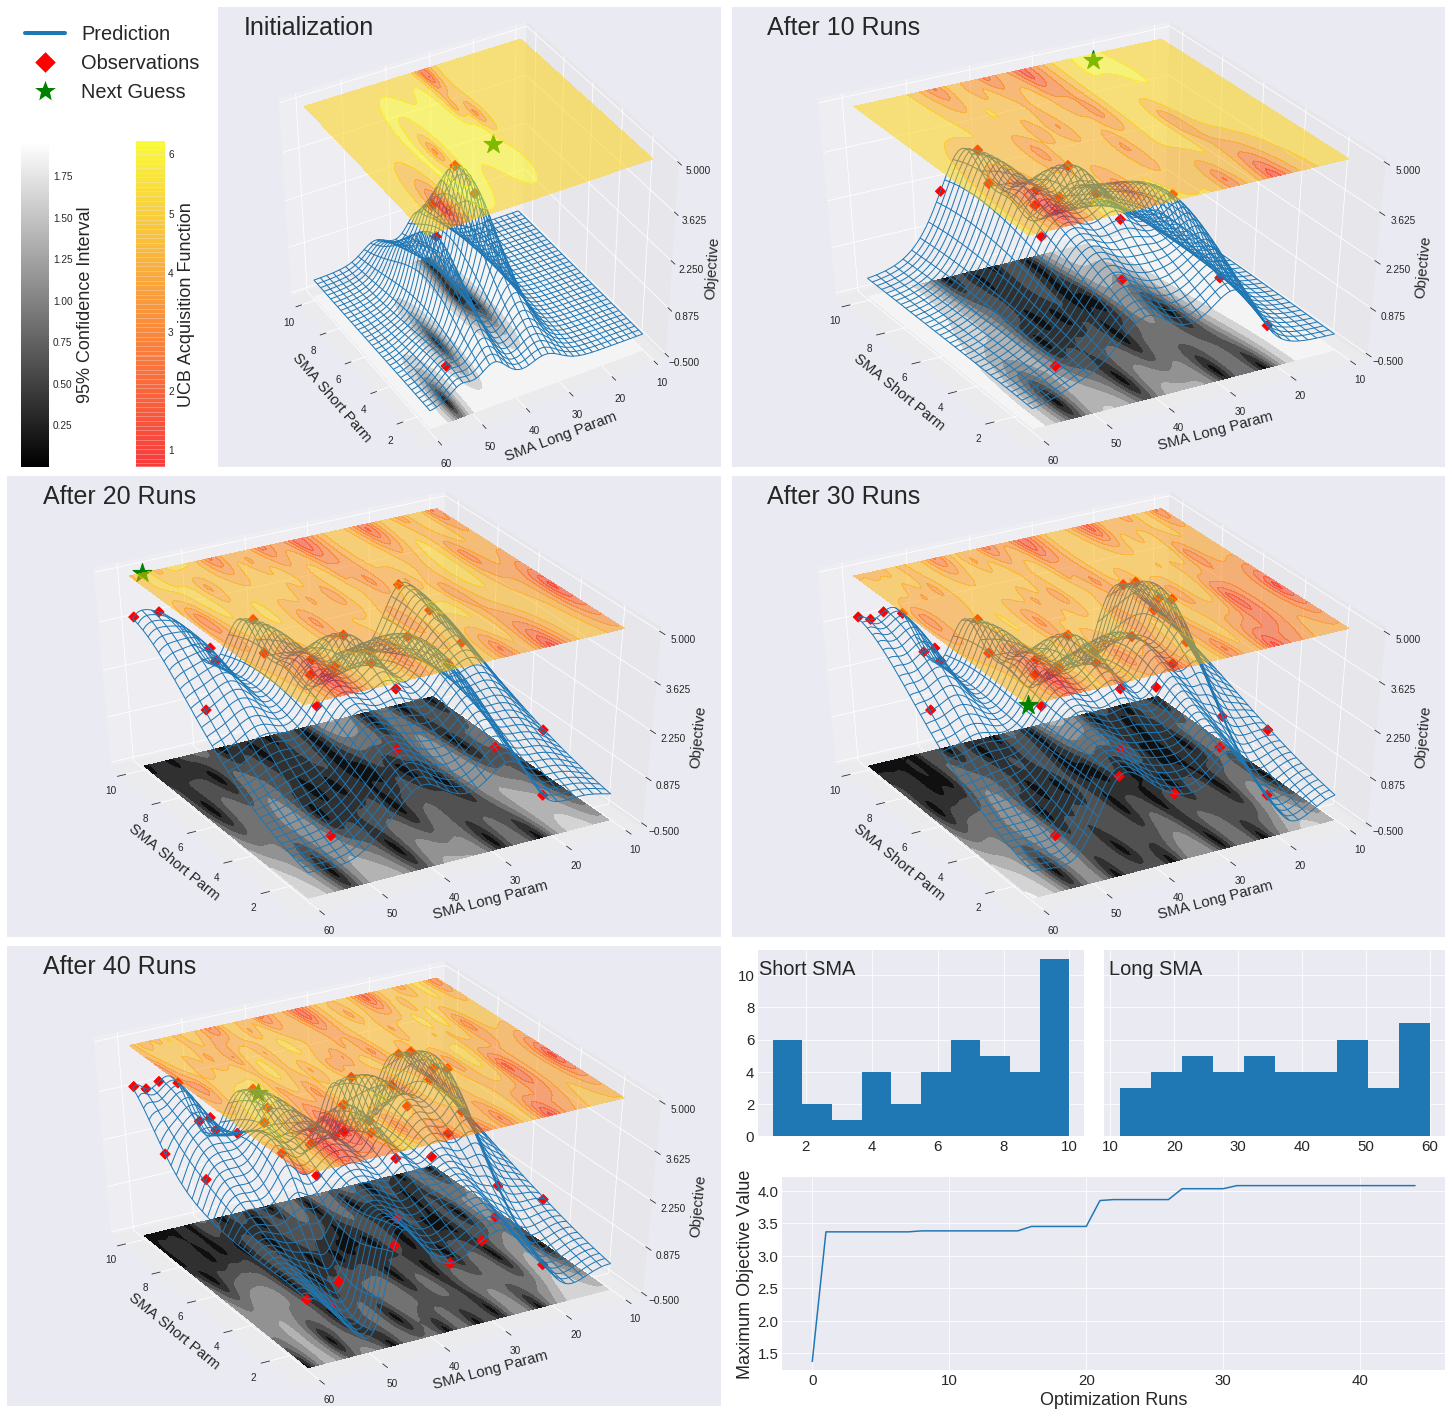

In [49]:
min_obj = 10
max_obj = 0
min_conf = 10
max_conf = 0
min_util = 10
max_util = 0

for data in datas:
    min_obj = np.min([np.min(data['mu']),min_obj])
    max_obj = np.max([np.max(data['mu']),max_obj])
    min_conf = np.min([np.min(data['conf']),min_conf])
    max_conf = np.max([np.max(data['conf']),max_conf])
    min_util = np.min([np.min(data['utility']), min_util])
    max_util = np.max([np.max(data['utility']), max_util])

if int(min_obj)-0.5>min_obj:
    min_obj=int(min_obj)-1
else: min_obj = int(min_obj)-0.5
if int(max_obj)+0.5 > max_obj:
    max_obj=int(max_obj)+1
else: max_obj=int(max_obj)+0.5



fig = plt.figure(figsize=(20,20))
#
i=1
first=True
clrAxes = None
for data in datas:
    ax = fig.add_subplot(3,2,i, projection='3d')
 
    plot_gp(xx_plot,yy_plot,data,min_obj=min_obj, max_obj=max_obj, min_util=min_util, max_util=max_util,
    min_conf=min_conf,max_conf=max_conf,ax=ax)
    
    if first:
        ax1_divider=make_axes_locatable(ax)
        cax1 = ax1_divider.append_axes("left", size='40%', pad='2%')
        cax1.set_facecolor('w')
        cax1.axis('off')
        legened_elements = [Line2D([0],[0],color='C0',label='Prediction',lw=4),
                   Line2D([0],[0],marker='D',color='w', markerfacecolor='r',label='Observations',markersize=15),
                   Line2D([0],[0],marker='*',color='w',markerfacecolor='g',label='Next Guess',markersize=25)]
        cax1.legend(handles=legened_elements, loc='upper left',fontsize=20)

        first=False
    ax.text2D(0.05, 0.94, data['title'], transform=ax.transAxes, fontsize=25)
    i+=1
data = pd.DataFrame(bo.X,columns=['Short SMA', 'Long SMA'])

##histogram short SMA
ax = fig.add_subplot(6,4,19)
ax.hist(data['Short SMA'])
#plt.setp(ax.get_xticklabels(), visible=False)
#ax.set_xlabel("Short SMA", fontsize=18)
ax.text(0.15,0.9, 'Short SMA',  fontsize=20,ha='center', va='center', transform=ax.transAxes)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)

##histogram long SMA
ax2 = fig.add_subplot(6,4,20,sharey=ax)
ax2.hist(data['Long SMA'])
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), fontsize=15)
plt.setp(ax2.get_yticklabels(), fontsize=15)
#ax2.set_xlabel("Long SMA",fontsize=18)
ax2.text(0.15,0.9, 'Long SMA', fontsize=20,ha='center', va='center', transform=ax2.transAxes)

## max sharpe ratio vs optimization steps
ax3 = fig.add_subplot(6,2,12)

max_sharpe = [bo.Y[0]]
for sharpe in bo.Y[1:]:
    if sharpe > max_sharpe[-1]:
        max_sharpe.append(sharpe)
    else: max_sharpe.append(max_sharpe[-1])
ax3.plot([x for x in range(len(max_sharpe))], max_sharpe)
plt.setp(ax3.get_xticklabels(), fontsize=15)
plt.setp(ax3.get_yticklabels(), fontsize=15)
#ax3.set_title("Maximum Objective", fontsize=18)
ax3.set_xlabel("Optimization Runs", fontsize=18)
ax3.set_ylabel("Maximum Objective Value", fontsize=18)

##color bars

ax5 = fig.add_axes([0.01, 0.68, 0.02, 0.226])
cbar_conf = mpl.colorbar.ColorbarBase(ax5, cmap=cm.gray, norm=mpl.colors.Normalize(vmin=min_conf, vmax=max_conf))
cbar_conf.set_clim(min_conf, max_conf)
cbar_conf.set_label("95% Confidence Interval", fontsize=18)
#cbar.ax.tick_params(labelsize=30)
ax6 = fig.add_axes([0.09, 0.68, 0.02, 0.226])
cbar_util = mpl.colorbar.ColorbarBase(ax6, cmap=cm.autumn, norm=mpl.colors.Normalize(vmin=min_util, vmax=max_util),alpha=0.5)
cbar_util.set_clim(min_util, max_util)
cbar_util.set_label('UCB Acquisition Function', fontsize=18)

##adjust positions of subplots
fig.tight_layout(pad=0.1, w_pad=-4, h_pad=-4)
box = ax.get_position()
box.x0 = box.x0+0.02
#box.x1 = box.x1+0.01
box.y0 = box.y0+0.025
box.y1 = box.y1-0.005
ax.set_position(box)
box = ax2.get_position()
box.x0 = box.x0+0.01
#box.x1 = box.x1+0.015
box.y0 = box.y0+0.025
box.y1 = box.y1-0.005
ax2.set_position(box)
box = ax1.get_position()
box.x0 = box.x0+0.025
ax1.set_position(box)
box = ax3.get_position()
box.x0 = box.x0+0.035
box.y0 = box.y0+0.025
ax3.set_position(box)

fig.show()

In [50]:
bo.Y[np.argmax(bo.Y)], bo.X[np.argmax(bo.Y)]

(4.079554713851788, array([ 6.76663509, 21.8089139 ]))

In [52]:
bo.points_to_csv('results/boSMA.csv')

## Results

The best values for short and long SMA parameters where at 7 and 22.

We will run a test with these parameters on the testing time period 2016 and 2017.

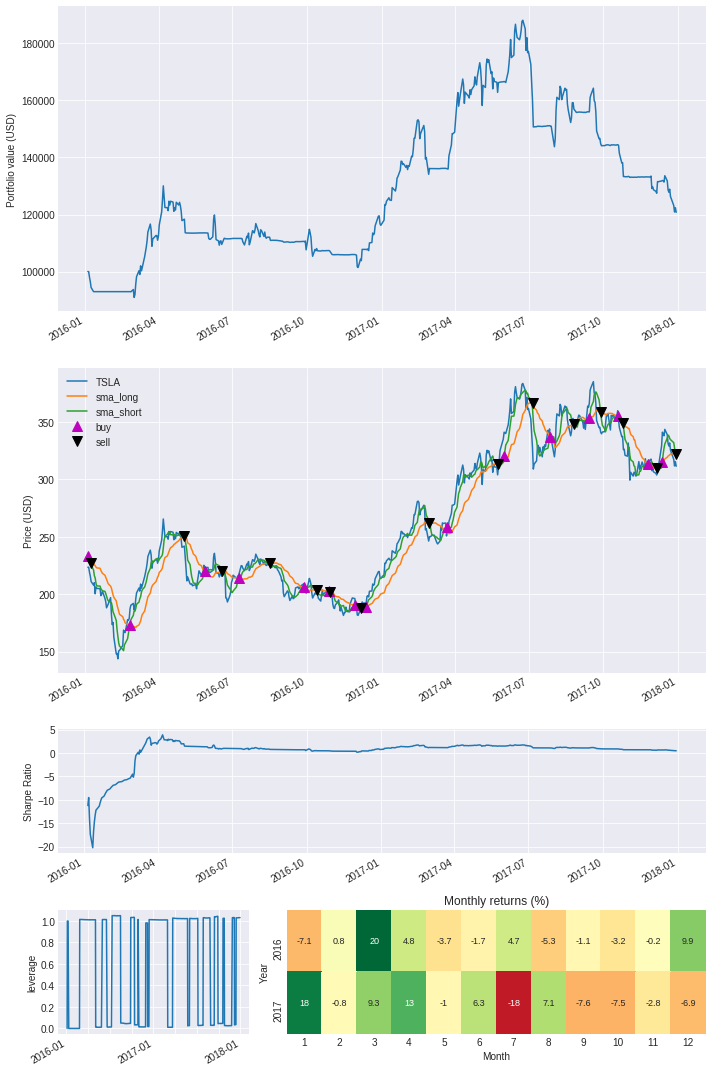

In [51]:
param['SMA_short'] = int(round(bo.X[np.argmax(bo.Y)][0]))
param['SMA_long'] = int(round(bo.X[np.argmax(bo.Y)][1]))

results = run_algorithm(env['test']['start_time'], env['test']['end_time'],
                        initialize=initialize,capital_base=env['capital'], analyze=analyze)    


In [53]:
results.to_pickle("results/SMA.pickle")

The result of SMA(7,22) is worse than our benchmark Buy&Hold strategy. Although in some periods it was able to make good decisions. In many cases SMA is not able to predict the movement fast enough to make a decision. Which can have a high risk in trading!

## Conclusion
SMA by itself is a very simple strategy that was not able to get a good return on the TSLA stock. We will next combine SMA with EMA strategy which can detect the movement trend faster than SMA as it EMA gives a higher priority to most recent days.